## Building MultiModal Search with Vector Databases

#### 👉🧠🤓 How build multi-modal search (image, audio, video) Meta AI ImageBind model (multi2vec-bind).
`ImageBind` allows us to search through text, images, audio and video files.

* Source: [Weaviate Sample Notebook: How build multi-modal search (image, audio, video) Meta AI ImageBind model (multi2vec-bind)](https://github.com/weaviate-tutorials/multimodal-workshop/blob/main/2-multimodal/1-multimedia-search-complete.ipynb)


### ◻️ Weaviate Setup
The `ImageBind` model is only available with **local Weaviate deployments** with **Docker** or **Kubernetes**.

⚠️`ImageBind` is <u>not supported with</u> **Weaviate Cloud Services (WCS)**.

### ◻️ Steps to deploy Weaviate locally with ImageBind

##### Dependences
`STEP 1: `
```bash
pip install -U weaviate-client
! pip install --pre -I "weaviate-client==4.4.1"  
# Using --pre indicates that you are installing a development version, which may not be completely stable. 
# Using -I indicates that conflicting dependencies should be ignored during installation.
```

`STEP 2`: Create a local Docker instance

- 1. Install Docker on your machine
 [Docker Compose Installation Guide](https://docs.docker.com/compose/install/)

- 2. Create a Docker Compose File

#### How to configure a Docker Compose file to run Weaviate with Meta's ImageBind model.

`Example`: docker-compose.yml
```bash
services:
  weaviate:
    command:
    - --host
    - 0.0.0.0
    - --port
    - '8080'
    - --scheme
    - http
    image: cr.weaviate.io/semitechnologies/weaviate:1.32.9
    ports:
    - 8080:8080
    - 50051:50051
    volumes:
    - weaviate_data:/var/lib/weaviate
    restart: on-failure:0
    environment:
      CLIP_INFERENCE_API: 'http://multi2vec-clip:8080'
      QUERY_DEFAULTS_LIMIT: 25
      AUTHENTICATION_ANONYMOUS_ACCESS_ENABLED: 'true'
      PERSISTENCE_DATA_PATH: '/var/lib/weaviate'
      ENABLE_MODULES: 'multi2vec-clip'
      ENABLE_API_BASED_MODULES: 'true'
      CLUSTER_HOSTNAME: 'node1'
  multi2vec-clip:
    image: cr.weaviate.io/semitechnologies/multi2vec-clip:sentence-transformers-clip-ViT-B-32-multilingual-v1
    environment:
      ENABLE_CUDA: '0'
volumes:
  weaviate_data:
```

`STEP 3`: Run Weaviate & ImageBind with Docker Compose
To start the docker image defined in the docker-compose.yml file, call:

```bash
Weaviate_Tutorial_Building_Multimodal_Search_DB/docker compose up
```


#### Result
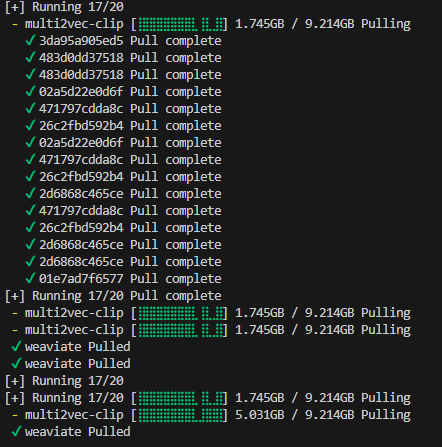

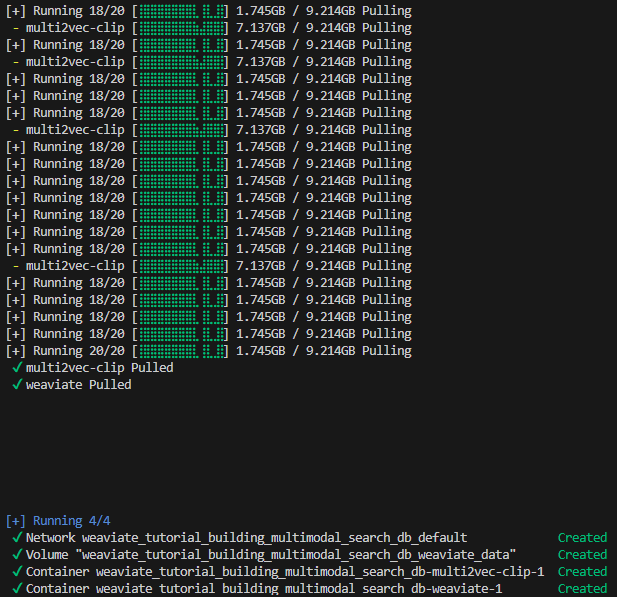

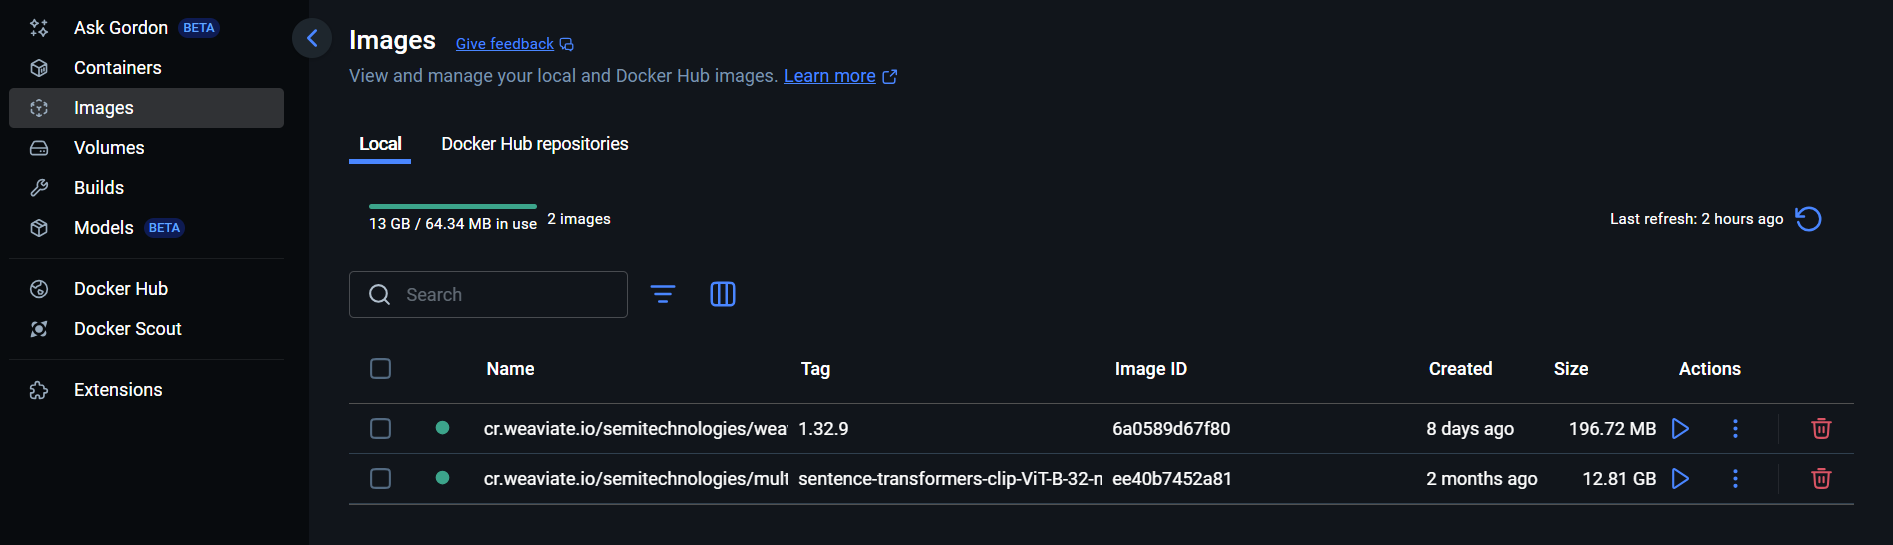
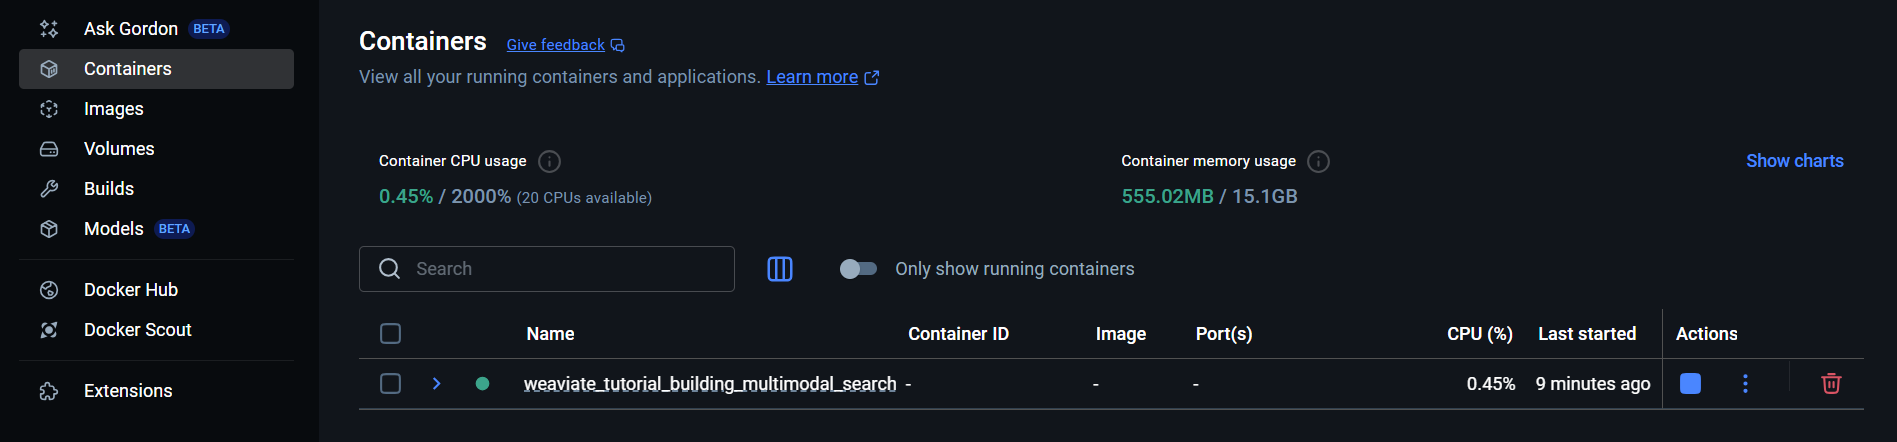
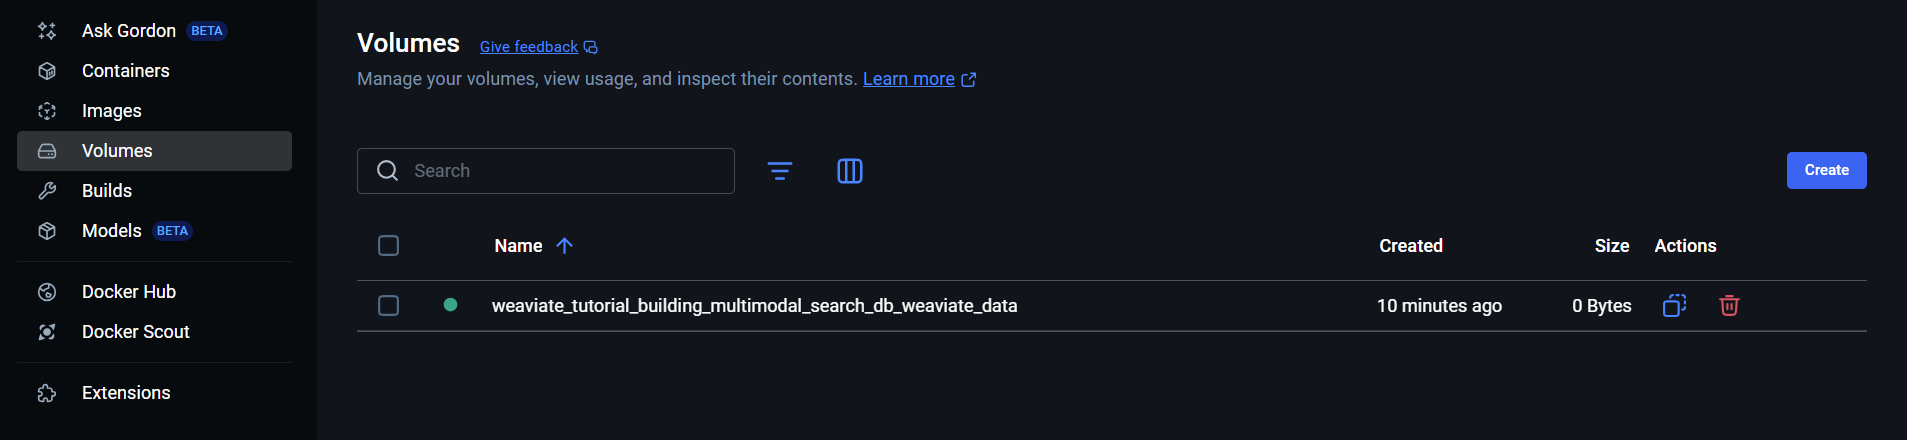


### ◻️ Connect to Weaviate

```bash
import weaviate, os

# Establishes a local connection to the Weaviate server.
client = weaviate.connect_to_local() 

# Checks if the Weaviate server is ready to receive requests.
client.is_ready() 

# Gets metadata information from the Weaviate server (version, configured properties)
client.get_meta()
```

In [117]:
import weaviate
import json
import weaviate.classes.config as wc
import weaviate.classes.query as wq
import pandas as pd
import os
import io
import base64
from PIL import Image

In [2]:
client = weaviate.connect_to_local()

In [3]:
client.is_ready()

True

In [ ]:
client.get_meta()

{'grpcMaxMessageSize': 104858000,
 'hostname': 'http://[::]:8080',
 'modules': {'generative-anthropic': {'documentationHref': 'https://docs.anthropic.com/en/api/getting-started',
   'name': 'Generative Search - Anthropic'},
  'generative-anyscale': {'documentationHref': 'https://docs.anyscale.com/endpoints/overview',
   'name': 'Generative Search - Anyscale'},
  'generative-aws': {'documentationHref': 'https://docs.aws.amazon.com/bedrock/latest/APIReference/welcome.html',
   'name': 'Generative Search - AWS'},
  'generative-cohere': {'documentationHref': 'https://docs.cohere.com/reference/chat',
   'name': 'Generative Search - Cohere'},
  'generative-databricks': {'documentationHref': 'https://docs.databricks.com/en/machine-learning/foundation-models/api-reference.html#completion-task',
   'name': 'Generative Search - Databricks'},
  'generative-friendliai': {'documentationHref': 'https://docs.friendli.ai/openapi/create-chat-completions',
   'name': 'Generative Search - FriendliAI'},
 

In [6]:
metainfo = client.get_meta()
print(json.dumps(metainfo, indent=2))  # Print the meta information in a readable format

{
  "grpcMaxMessageSize": 104858000,
  "hostname": "http://[::]:8080",
  "modules": {
    "generative-anthropic": {
      "documentationHref": "https://docs.anthropic.com/en/api/getting-started",
      "name": "Generative Search - Anthropic"
    },
    "generative-anyscale": {
      "documentationHref": "https://docs.anyscale.com/endpoints/overview",
      "name": "Generative Search - Anyscale"
    },
    "generative-aws": {
      "documentationHref": "https://docs.aws.amazon.com/bedrock/latest/APIReference/welcome.html",
      "name": "Generative Search - AWS"
    },
    "generative-cohere": {
      "documentationHref": "https://docs.cohere.com/reference/chat",
      "name": "Generative Search - Cohere"
    },
    "generative-databricks": {
      "documentationHref": "https://docs.databricks.com/en/machine-learning/foundation-models/api-reference.html#completion-task",
      "name": "Generative Search - Databricks"
    },
    "generative-friendliai": {
      "documentationHref": "http

### ◻️ Create `WomenShoesMM` Collection

In [120]:
# Check if a collection named "Animals" exists on the Weaviate server. If the collection exists, delete it.
if(client.collections.exists("WomenShoesMM")):
    client.collections.delete("WomenShoesMM")

In [121]:
client.collections.create(
    name="WomenShoesMM",  # The name of the collection ('MM' for multimodal)
    properties=[
        wc.Property(name="shoe_id", data_type=wc.DataType.INT),
        wc.Property(name="description", data_type=wc.DataType.TEXT),
        wc.Property(name="image_path", data_type=wc.DataType.TEXT),
        wc.Property(name="image", data_type=wc.DataType.BLOB),
    ],
    # Define & configure the vectorizer module
    vector_config=wc.Configure.Vectors.multi2vec_clip(
        image_fields=[wc.Multi2VecField(name="image")],   
        text_fields=[wc.Multi2VecField(name="description")]
    ),
)


In [122]:
df = pd.read_csv('data/women_shoes.csv')
df.head()

,name,description,price,currency,terms,image_downloads,extracted_footwear_type,iso_image
0,PEARL HEELED SLINGBACKS,Slingback heels with front pearl detail. Point...,79.9,USD,shoes,"['82aaf07d-4981-46d9-ab54-56d82c40cfa5', 'ea8b...",SLINGBACKS,ea8b9976-7cda-4e4c-9926-b357b1aa65c7
1,LEATHER BALLET FLATS,Mary Jane style leather ballet flats. Buckled ...,59.9,USD,shoes,"['3c5a4b1d-407b-4683-8489-795e1177aa4a', '769a...",BALLET FLATS,769a6f42-94a6-451b-9014-5fcf1100d212
2,HIGH HEEL SLINGBACK PUMPS,Heeled slingbacks with faux patent leather fin...,49.9,USD,shoes,"['7b6e1e93-8567-4a59-8896-3785b4bbec7a', '19b8...",SLINGBACK PUMPS,19b80e65-67a9-45f8-8139-e7b1da2ab448
3,HIGH HEEL SLINGBACK PUMPS,Heeled faux patent leather slingbacks. Back st...,49.9,USD,shoes,"['afe05bc6-32c5-4491-960a-2b0e650a8d68', 'deb5...",SLINGBACK PUMPS,deb51ea0-cb17-46ef-b381-77472db4f023
4,BLOCK HEEL SLINGBACK SHOES,Slingback block heel pumps. Front strap with b...,49.9,USD,shoes,"['7c892e0a-dba6-481a-bacf-e3698260be0e', 'f60a...",NaN,f60acf01-96a7-44cf-9245-ba3a2ef57920


In [123]:
# directory of original images
IMAGE_FOLDER_WOMEN = "images"

# Get all image URIs from the folder '../data/iso_women_shoes/' and store them in a list.
women_image_uris = [os.path.join(IMAGE_FOLDER_WOMEN, image).replace("\\", "/") for image in os.listdir(IMAGE_FOLDER_WOMEN)]
print(women_image_uris)

['images/0e30729e-73cd-44de-a861-42b0a4754aec.png', 'images/0e9b17d4-c9f8-42af-8086-65d5ea13ea08.png', 'images/11b5859c-930e-4d79-8b2b-da82c88ef8f7.png', 'images/fae78e98-569a-4690-b696-2a2078bef043.png']


In [124]:
def get_name_picture(image_uri: str) -> str:
    """Extract the name of the picture from the image URI."""
    return os.path.basename(image_uri).split('.')[0]

In [125]:
women_image_ids = [get_name_picture(img) for img in women_image_uris]
women_image_ids

['0e30729e-73cd-44de-a861-42b0a4754aec',
 '0e9b17d4-c9f8-42af-8086-65d5ea13ea08',
 '11b5859c-930e-4d79-8b2b-da82c88ef8f7',
 'fae78e98-569a-4690-b696-2a2078bef043']

In [126]:
def create_description_files(df: pd.DataFrame, women_image_ids: list, description_folder: str = "descriptions") -> None:
    """Create text files for each description in the dataframe.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        description_folder (str): Folder to save the description files.
        women_image_ids (list): List of image IDs.
    """

    for index, row in df.iterrows():
        if row['iso_image'] in women_image_ids:
            file_name =  os.path.join(description_folder, row['iso_image']+".txt").replace("\\", "/")
            with open(file_name, 'w') as f:
                f.write(row['description'])
        

In [127]:
# Create description files for the images
create_description_files(df, women_image_ids)

### ◻️ Insert Images into Weaviate



In [128]:
# Helper function to convert a file to base64 representation
def toBase64(path):
    with Image.open(path) as img:
        img_bytes = io.BytesIO()
        img.save(img_bytes, format='PNG')
        img_bytes.seek(0)
        return base64.b64encode(img_bytes.getvalue()).decode('utf-8')

In [129]:
img_base64 = toBase64("images/0e9b17d4-c9f8-42af-8086-65d5ea13ea08.png")
print(type(img_base64))
print(img_base64[:100])  # Print the first 100 characters of the base64 string

<class 'str'>
iVBORw0KGgoAAAANSUhEUgAABqQAAAXGCAYAAADmBM70AAEAAElEQVR4nOz955MkyZbliV1lxpwESVJZ5L16tHu6Z7t7BrIzi53F


In [130]:
def get_description(des_path: str) -> str:
    """Read the content of a description file and return it as a string."""
    with open(des_path, 'r') as file:
        return file.read()

In [131]:
img_description = get_description("descriptions/0e9b17d4-c9f8-42af-8086-65d5ea13ea08.txt")
print(type(img_description))
print(img_description)  # Print the description text

<class 'str'>
Heeled faux patent leather shoes. Ankle strap buckle closure. Thin heel. Rounded toe.

Heel height: 3.5 inches (9 cm)


In [132]:
items = []
new_item= {
        "shoe_id": 1,
        "description": img_description,
        "image": img_base64,
    }
items.append(new_item)
items

[{'shoe_id': 1,
  'description': 'Heeled faux patent leather shoes. Ankle strap buckle closure. Thin heel. Rounded toe.\n\nHeel height: 3.5 inches (9 cm)',
  'image': 'iVBORw0KGgoAAAANSUhEUgAABqQAAAXGCAYAAADmBM70AAEAAElEQVR4nOz955MkyZbliV1lxpwESVJZ5L16tHu6Z7t7BrIzi53FQvDvAt8ggi8QgQACWcEHACvDepo8XjRpZER4ODGqqivnqpqHhWdEkiL9iuh5HeXM3Ny4Zd+fnnMFJSUlJSUlJSUlJSUlJSUlfaMSQog3TeO9928zn3G6t5nnd0lvs35JSUlJST8MfZP3qHT/SEr64ep79Y/ZpKSkpKSkpKSkpKSkpKTvir5vgOj7qlSYTEpKSvpq+iHfp9K9ISnp+6kf7EUpKSkpKSkpKSkpKSkpKenPVeD7IRcBvyuFwO/CMiQlJSV9F/RDv+e8Sel+kJT0/dGP+mKVlJSUlJSUlJSUlJSUlPRNFv6+K0XBMerv8PGHWhRMxcikpKQfq74r951vYpm+7rU83QuSkr77+s5dsJKSkpKSkpKSkpKSkpKSvst6U6Htu1gc/LaVQFRSUlLSn0ff9XvOm5bvm7qOp/tBUtL3Q9/pC1ZSUlJSUlJSUlJSUlJS0g+hCPg2047FtHeZ7+h+etvpD3/ru6zvwzImJSUlfd902z3jtuvtdxl0pftDUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlLSD0zf2SzQpKSkpKSkpKSkpKSkpKSkpLv0Xe5vkpT0Y9Tb9vXBuZt6AH07fZ9+7HrTfSFts6SkP7/SP96SkpKSkpKSkpKSkpKSkpJ+ELBpLHR/32DV

### Add list of items to the collection

In [134]:
images_file_names = os.listdir("images/")
items = list()
for index, name in enumerate(images_file_names):
    items.append({
        "shoe_id": index,
        "description": get_description(f"descriptions/{name.split('.')[0]}.txt"),
        "image_path": f"images/{name}",
        "image": toBase64(f"images/{name}"),
    })


In [135]:
women_shoes_mm = client.collections.get("WomenShoesMM")
women_shoes_mm.data.insert_many(items)

BatchObjectReturn(_all_responses=[UUID('54852bef-a0a9-4f6b-b7c3-14ad0c69dbd3'), UUID('70bfaab7-6388-4424-880a-b38e685a7e53'), UUID('5eeea058-efc7-4fc7-acc1-17a53da1ff8d'), UUID('56a5b78d-1158-4465-8546-3acc98568f9f')], elapsed_seconds=1.5132582187652588, errors={}, uuids={0: UUID('54852bef-a0a9-4f6b-b7c3-14ad0c69dbd3'), 1: UUID('70bfaab7-6388-4424-880a-b38e685a7e53'), 2: UUID('5eeea058-efc7-4fc7-acc1-17a53da1ff8d'), 3: UUID('56a5b78d-1158-4465-8546-3acc98568f9f')}, has_errors=False)

## Multimodal Search

###  Image to Image

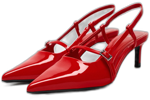

In [146]:
# Perform query
src_img_path = "test/ba7edcdc-6456-4e2f-b3c6-3a02cfc6309c.png"
display(Image.open(src_img_path).resize((150, 100)))
query_b64 = toBase64(src_img_path)


In [149]:
response = women_shoes_mm.query.near_image(
    near_image=query_b64,
    limit=2,
    return_metadata=wq.MetadataQuery(distance=True),
    return_properties=["shoe_id", "description", "image_path", "image"]  # To include the poster property in the response (`blob` properties are not returned by default)
)

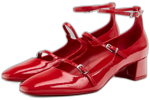

images/11b5859c-930e-4d79-8b2b-da82c88ef8f7.png Block heel Mary Jane shoes. Faux patent leather finish. Buckled straps.

Heel height: 1.6 inches (4 cm)

AIRFIT®. Flexible technical sole made of latex foam designed to offer increased comfort.
Distance to query: 0.164



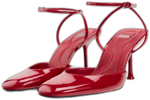

images/0e9b17d4-c9f8-42af-8086-65d5ea13ea08.png Heeled faux patent leather shoes. Ankle strap buckle closure. Thin heel. Rounded toe.

Heel height: 3.5 inches (9 cm)
Distance to query: 0.210



In [150]:
# Inspect the response
for o in response.objects:
    display(Image.open(o.properties["image_path"]).resize((150, 100)))
    print(
        o.properties["image_path"], o.properties["description"]
    ) # Print the shoe_id and description
    print(
        f"Distance to query: {o.metadata.distance:.3f}\n"
    )  # Print the distance of the object from the query

